In [23]:
import connector
from datetime import datetime, date, timedelta
from lifelines.utils import datetimes_to_durations
import numpy as np
from lifelines import NelsonAalenFitter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

save_directory = '/Users/rob/Downloads/conversion_kr_pictures/'
plt.style.use('seaborn-notebook')

## Background
- importing data
- cleaning data
- descriptive statistics

In [2]:
# get data from google sheet, then deal with google sheet's ridiculous data type issues
df = pd.DataFrame(connector.SheetConn('cohort_trial_data').sheet1.get_all_records())

#manually parsing string dates because gspread dtypes suck
sheets_date_format = '%Y-%m-%d %H:%M:%S'
df['start_dt'] = df['start_dt'].apply(lambda x: datetime.strptime(x, sheets_date_format))
df['completion_dt'] = df['completion_dt'].apply(lambda x: datetime.strptime(x, sheets_date_format) if x!='' else None)
#define cohorts by the day in which the user signed up for a trial
# this is often desirable for survival analysis since 
df['cohort'] = df['start_dt'].map(lambda x: x.day)

#use the lifelines datetimes_to_durations function for a observed (boolean) column and a duration (time it took to subscribe)
df['duration'], df['observed'] = datetimes_to_durations(df['start_dt']\
            , df['completion_dt'], fill_date='2019-04-01')

df['device'].replace('', np.NaN, inplace=True)
df['browser'].replace('', np.NaN, inplace=True)

df.set_index('id')[['device', 'browser', 'start_dt', 'cohort', 'completion_dt', 'observed', 'duration']].head()

,device,browser,start_dt,cohort,completion_dt,observed,duration
id,,,,,,,
51809381e4b03c6b86a6256f,tablet,safari,2018-07-15,15,2018-07-28 23:00:00,True,13.0
518093ade4b00cbd5d9abe26,NaN,NaN,2018-07-15,15,NaT,False,260.0
518093d6e4b0c1fda9c05d54,desktop,ie,2018-07-15,15,2018-07-29 20:00:00,True,14.0
518093f2e4b0b0f0caf55867,desktop,ie,2018-07-15,15,NaT,False,260.0
518093fee4b01eeb7aec8bfc,mobile,android,2018-07-15,15,NaT,False,260.0


### cleaning

In [3]:
#any weird data out there?
df[df.start_dt>df.completion_dt]

,browser,completion_dt,device,duration,id,observed,start_dt,cohort


In [4]:
df[(df.observed==True)&(pd.isnull(df.completion_dt))]

,browser,completion_dt,device,duration,id,observed,start_dt,cohort


In [5]:
df[(df.observed==False)&(pd.notnull(df.completion_dt))]

,browser,completion_dt,device,duration,id,observed,start_dt,cohort


In [6]:
df.isnull().sum()/len(df)

browser          0.058989
completion_dt    0.789417
device           0.055268
duration         0.000000
id               0.000000
observed         0.000000
start_dt         0.000000
cohort           0.000000
dtype: float64

In [7]:
df['id'].value_counts().nlargest(5)

51893b4ce4b0815517460f9c    2
5181052be4b0c9ccd7588c33    1
519318dee4b0ff3406115312    1
518e853ee4b05913b69d4123    1
518170c7e4b085d260adfc3b    1
Name: id, dtype: int64

In [8]:
#not always this easy but since the rows are the same this is fine
df.drop_duplicates(subset='id', inplace=True)

### descriptive stats

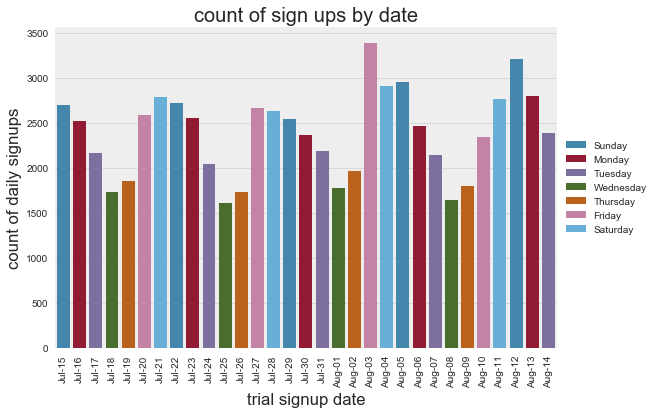

In [35]:
'''
there is weekly seasonality in signups- ther are more isgnups on the weekends and fewer on the weekdays. This is either a b
to c product or our users are a bunch of workaholics. 
'''
plt.style.use('bmh')
ax = sns.barplot(
    x='date_label'
    ,y='id'
    ,hue='dow'
    ,data=df.groupby(pd.Grouper(key='start_dt', freq='1d'))['id'].nunique().reset_index()\
            .assign(dow= lambda df_: df_['start_dt'].apply(lambda x: x.weekday_name))\
            .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    ,dodge=False
)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('count of sign ups by date')

ax.set_xlabel('trial signup date')
ax.set_ylabel('count of daily signups')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

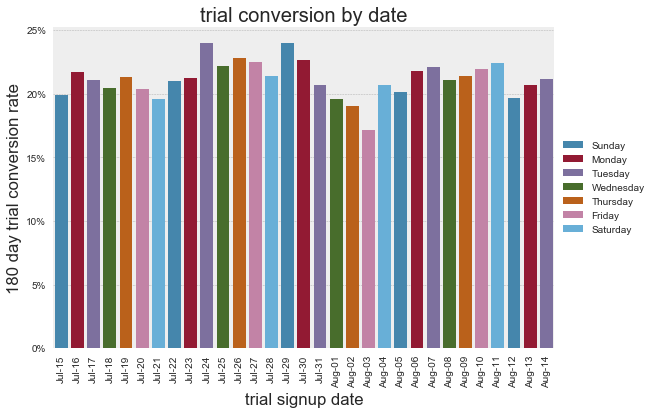

In [36]:
'''
conversion rate does not exhibit the same seasonality as frequency of signups. there might be some pattern at the hourly level but
let's not complicate things before we have to
'''

ax = sns.barplot(
    x='date_label'
    ,y='observed'
    ,hue='dow'
    ,data=df.groupby(pd.Grouper(key='start_dt', freq='1d'))['observed'].mean().reset_index()\
            .assign(dow= lambda df_: df_['start_dt'].apply(lambda x: x.weekday_name))\
            .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    ,dodge=False
)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('trial conversion by date')

ax.set_xlabel('trial signup date')
ax.set_ylabel('180 day trial conversion rate')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

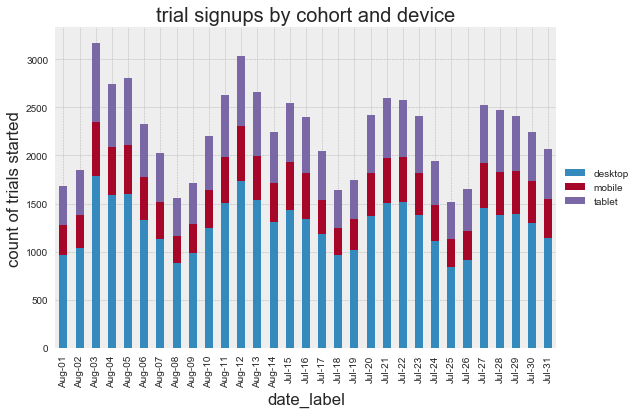

In [37]:
'''
most trials appear to be started on desktop. We could perform some cool statistical tests to see if the makeup of
device changes over this time period but there's no intiutive reason why it should and it certaintly doesn't appear 
to be an issue just by eyeballing the chart. let's move on to more exiciting things
'''
ax = pd.pivot_table(
    df\
    .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'device'])['id'].count().reset_index()
    ,index='date_label'
    ,columns='device'
).T.droplevel(0).T.plot(kind='bar', stacked=True)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('trial signups by cohort and device')

ax.set_ylabel('count of trials started')
plt.savefig('{}/{}'.format(save_directory, 'trial_signups_by_cohort_x_device.png'), bbox_inches='tight')

[Text(0, 0, '0%'),
 Text(0, 0, '20%'),
 Text(0, 0, '40%'),
 Text(0, 0, '60%'),
 Text(0, 0, '80%'),
 Text(0, 0, '100%'),
 Text(0, 0, '120%')]

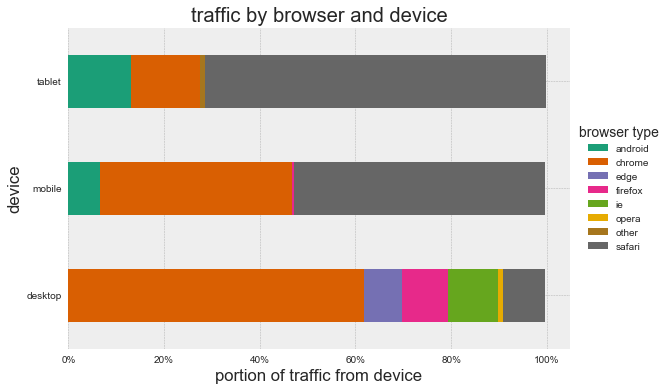

In [38]:
'''
just checking to see if something looks off about this
'''
ax = df.groupby(['browser','device']).size().unstack()\
    .div(df.groupby(['device']).size()).T\
.plot(kind='barh', stacked=True, colormap='Dark2')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='browser type')
ax.set_title('traffic by browser and device')

ax.set_xlabel('portion of traffic from device')
ax.set_ylabel('device')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])

In [13]:
'''
using scipy's chi squared test to see if the differences in conversion in devices are significant. They appear to be from our plot but it
(usually) can't hurt to check
'''

from scipy.stats import chi2_contingency
from scipy.stats import chi2
stat, p, dof, expected = chi2_contingency(\
                    df.groupby(['device', 'observed']).size().unstack())
stat, chi2.ppf(0.95, dof), abs(stat) >= chi2.ppf(0.95, dof), p<0.05

(1201.8808927362934, 5.991464547107979, True, True)

In [14]:
'''
while trials started on different devices convert at significantly different rates, the browser type does not
'''
chi_squared_results_browser = {}
for device in df.device.dropna().unique():
    stat, p, dof, expected = chi2_contingency(\
                    df[df.device==device].groupby(['browser', 'observed']).size().unstack())
    chi_squared_results_browser[device] = {'stat': stat, 'ppf': chi2.ppf(0.95, dof), 'is_significant': p<0.05}
pd.DataFrame(chi_squared_results_browser).T

,is_significant,ppf,stat
tablet,True,7.81473,8.44709
desktop,False,11.0705,8.6027
mobile,False,7.81473,0.265183


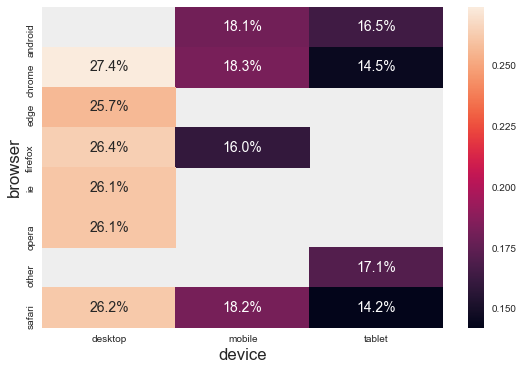

In [39]:
'''
a really ugly heatmap showing conversion by device and browser
'''
sns.heatmap(df[df.observed==True].groupby(['browser','device']).size().unstack()/\
df.groupby(['browser','device']).size().unstack(), annot=True, fmt=".1%")

### Conversion

[Text(0, 0, '4%'),
 Text(0, 0, '6%'),
 Text(0, 0, '8%'),
 Text(0, 0, '10%'),
 Text(0, 0, '12%'),
 Text(0, 0, '14%'),
 Text(0, 0, '16%'),
 Text(0, 0, '18%'),
 Text(0, 0, '20%'),
 Text(0, 0, '22%')]

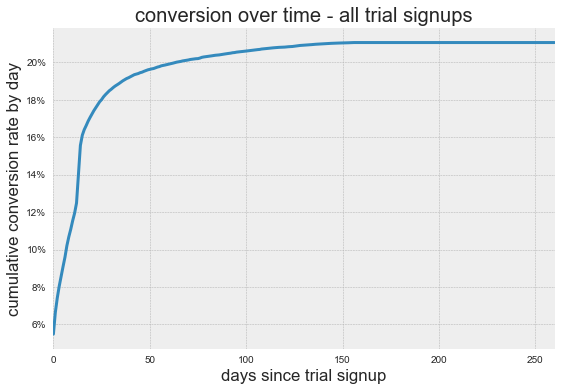

In [40]:
ax = (df.groupby(['duration'])['observed'].sum().cumsum()/len(df)).plot(linewidth=3)
ax.set_title('conversion over time - all trial signups')
ax.set_ylabel('cumulative conversion rate by day')
ax.set_xlabel('days since trial signup')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])

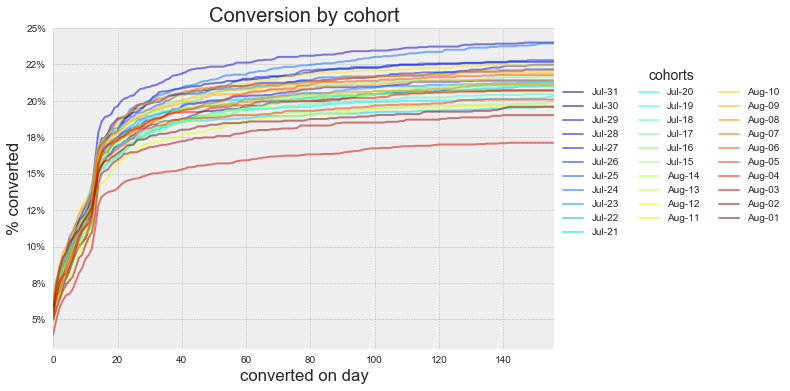

In [41]:
ax = pd.pivot_table(
    df[df.observed==True]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1)\
.plot(colormap='jet', alpha=0.5)

ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.0, 0.9), title='cohorts')
ax.set_title('Conversion by cohort')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')
plt.savefig('{}/{}'.format(save_directory, 'unadjusted_conversion_by_cohort.png'), bbox_inches='tight')

Text(0.5, 0, 'conversion rate')

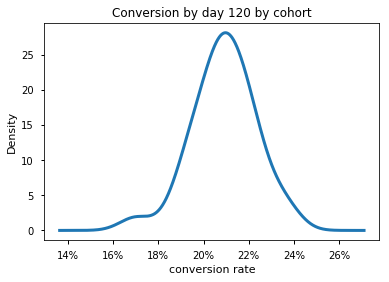

In [19]:
ax = pd.pivot_table(
    df[df.observed==True]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1).loc[120]\
.plot(kind='density', linewidth=3)

ax.set_title('Conversion by day 120 by cohort')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate')

Text(0, 0.5, '% converted')

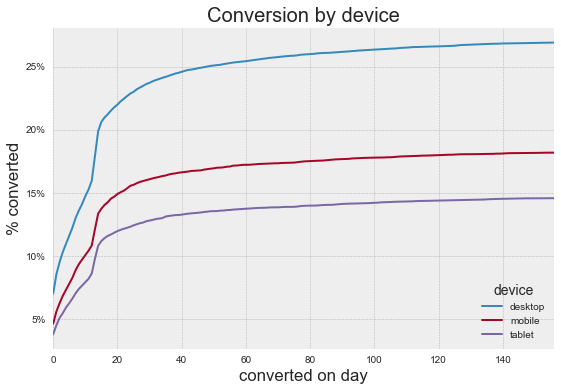

In [42]:
ax = pd.pivot_table(
    df[df.observed==True]\
        .groupby(['device', 'duration'])['id'].count().reset_index()
    ,index='device'
    ,columns='duration'
).T.fillna(0).droplevel(level=0).cumsum().div(df.groupby(['device'])['id'].count()).plot()

ax.set_title('Conversion by device')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')

Text(0, 0.5, 'cumulative conversions')

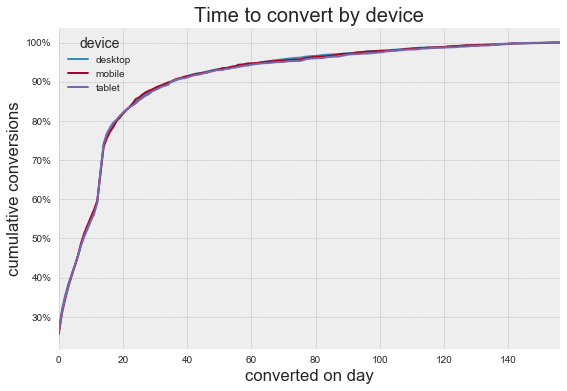

In [43]:
'''
While the groups differ significantly in terms of eventual trial conversion, they appear to all follow the same trajectory
to their eventual conversion rate. Another way to say this is that each group's conversion rate remains _proportional_ to 
one another. 
'''

ax = pd.pivot_table(
    df[df.observed==True]\
        .groupby(['device', 'duration'])['id'].count().reset_index()
    ,index='device'
    ,columns='duration').T.fillna(0).droplevel(level=0).cumsum().div(df[df.observed==True].groupby(['device'])['id'].count()).plot()

ax.set_title('Time to convert by device')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('cumulative conversions')

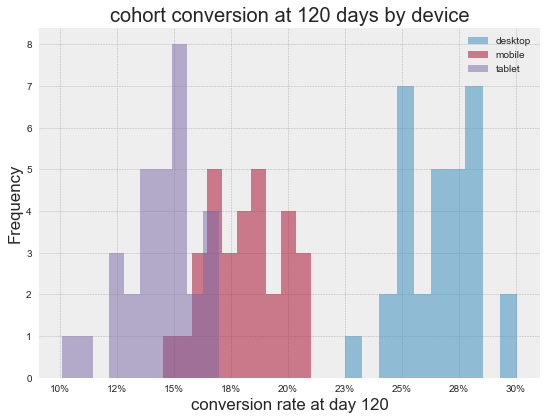

In [44]:
'''
another way to see the huge differences by device
'''
fig, ax = plt.subplots(figsize=(8,6))

pd.pivot_table(
    df[df.observed==True]\
        .groupby(['cohort', 'device', 'duration'])['id'].count().groupby(level=[0,1]).cumsum().reset_index()
    ,index='duration'
    ,columns=['cohort', 'device']
    ,values='id'
)\
    .ffill().loc[120]\
    .div(df.groupby(['cohort', 'device'])['id'].count())\
    .groupby('device', level=1)\
    .plot(ax=ax, kind='hist', linewidth=3, legend=True, alpha=0.5)

ax.set_title('cohort conversion at 120 days by device')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate at day 120')
plt.savefig('{}/{}'.format(save_directory, 'device_conversion_by_cohort.png'), bbox_inches='tight')

Text(0.5, 1.0, 'eventual conversion rate baseline: simple device adjustements')

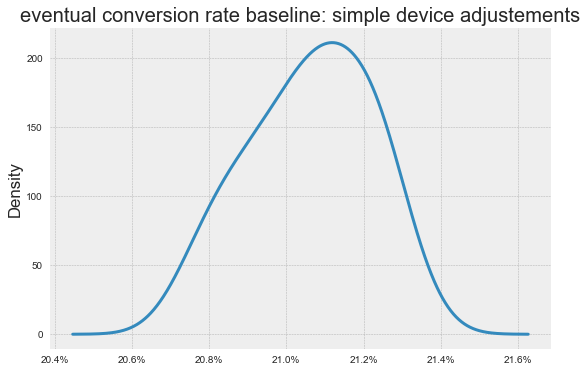

In [45]:
device_conversion = df.groupby('device')['observed'].mean().to_dict()
ax = pd.concat([
    df[df.device=='desktop'].groupby('cohort')['id'].count().apply(lambda x: x*device_conversion['desktop']).rename('desktop')
    ,df[df.device=='mobile'].groupby('cohort')['id'].count().apply(lambda x: x*device_conversion['mobile']).rename('mobile')
    ,df[df.device=='tablet'].groupby('cohort')['id'].count().apply(lambda x: x*device_conversion['tablet']).rename('desktop')
], axis=1).sum(axis=1).div(df.groupby('cohort')['id'].count()).plot(kind='density', linewidth=3)


ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_title('eventual conversion rate baseline: simple device adjustements')


### Regression
we need a way to adjust our estimates for device types. This assumes we don't anticipate any changes to the makeup of device types (i.e. a mobile app would definitely violate this) but it's a start

#### CPH

In [46]:
def create_regression_df(df, dummy_cols, split=False, prefix='device'):
    regression_df = pd.concat([
        df.drop(dummy_cols, axis=1)
        ,pd.get_dummies(df[dummy_cols]\
                        ,dummy_na=False, prefix=prefix, drop_first=True)
    ], axis=1)
    if split==True:
        X_train, X_test = train_test_split(regression_df, test_size=0.33)
        return X_train, X_test
    return regression_df

In [47]:
X_train, X_test = create_regression_df(
                          df.set_index(['cohort', 'id'])\
                            [['observed', 'duration', 'device']]\
                          ,dummy_cols=['device']\
                          ,split=True)
X_train[X_train.duration==120].head()

,,observed,duration,device_mobile,device_tablet
cohort,id,,,,
3,519a662ee4b0d23698c15077,True,120.0,0,0


<lifelines.CoxPHFitter: fitted with 49508 observations, 39073 censored>
      duration col = 'duration'
         event col = 'observed'
number of subjects = 49508
  number of events = 10435
    log-likelihood = -111331.25
  time fit was run = 2019-04-29 14:49:12 UTC

---
               coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
device_mobile -0.31      0.73      0.03 -11.36 <0.005     96.86       -0.37       -0.26
device_tablet -0.59      0.56      0.03 -21.63 <0.005    342.21       -0.64       -0.54
---
Concordance = 0.56
Log-likelihood ratio test = 567.49 on 2 df, -log2(p)=409.36


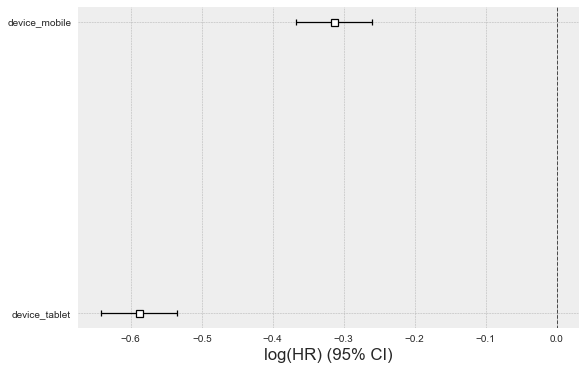

In [48]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(X_train, duration_col='duration', event_col='observed')
cph.print_summary()
cph.plot()

In [49]:
cph.check_assumptions(X_train, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


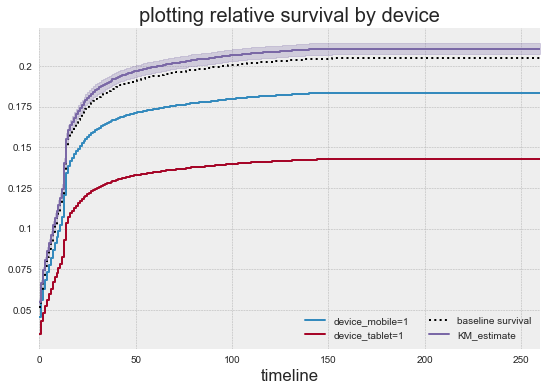

In [50]:
#plotting 1 - survival curve. This is more intuitive way to think about it and converting from hazards to survival sucks
ax = cph.plot_covariate_groups(['device_mobile', 'device_tablet'], values=np.eye(2))

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(X_train['duration'], event_observed=X_train['observed'])
ax = kmf.plot(ax=ax, invert_y_axis=True)
ax.set_title('plotting relative survival by device')
ax.legend(loc=4, ncol=2)

### AAF

<lifelines.AalenAdditiveFitter: fitted with 49508 observations, 39073 censored>
      duration col = 'duration'
         event col = 'observed'
    coef penalizer = '1.0'
number of subjects = 49508
  number of events = 10435
  time fit was run = 2019-04-29 14:49:17 UTC

---
               slope(coef)  se(slope(coef))
device_mobile        -0.00             0.01
device_tablet        -0.00             0.02
_intercept            0.00             0.05
---
Concordance = 0.56


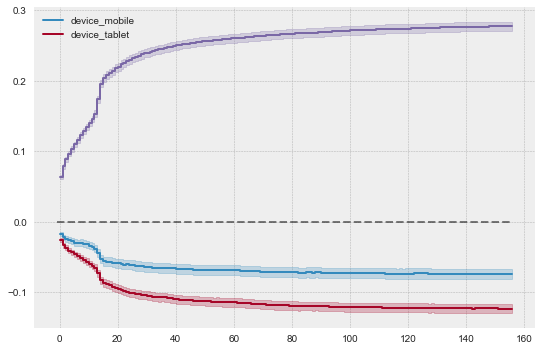

In [51]:
from lifelines import AalenAdditiveFitter

aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
aaf.fit(X_train, 'duration', event_col='observed')
aaf.print_summary()
aaf.cumulative_hazards_.head()
aaf.plot()

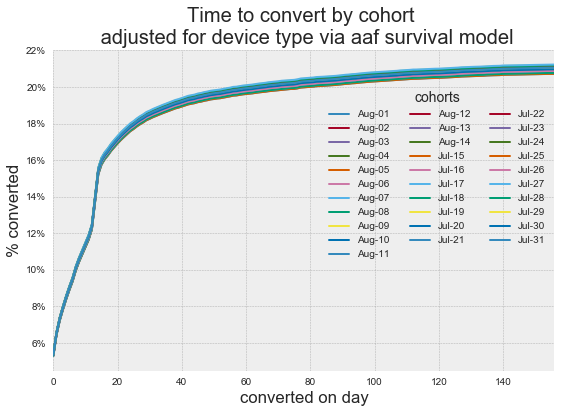

In [52]:
ax = pd.concat([
    aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
    ,df[df.id.isin(X_test.index.levels[1])].reset_index().set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
], axis=1, join='inner').groupby('cohort').mean().T.plot()

ax.legend(loc=0, ncol=3, bbox_to_anchor=(1.0, 0.9), title='cohorts')
ax.set_title('Time to convert by cohort \n adjusted for device type via aaf survival model')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')
plt.savefig('{}/{}'.format(save_directory, 'adjusted_conversion_by_cohort.png'), bbox_inches='tight')

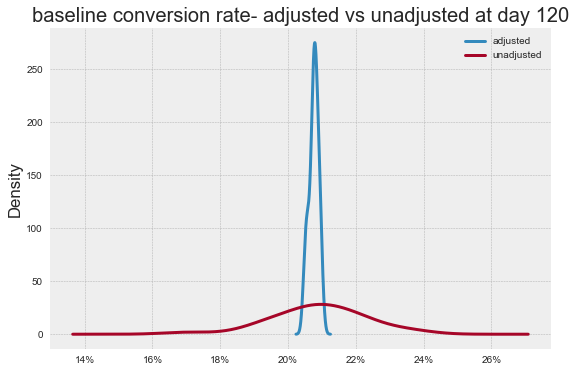

In [53]:
'''
same mean, just way less variance
'''
ax = pd.concat([
    cph.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
    ,df[df.id.isin(X_test.index.levels[1])].reset_index().set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
], axis=1, join='inner').groupby('cohort').mean()[120].plot(kind='density', linewidth=3, label='adjusted')

pd.pivot_table(
    df[(df.observed==True)&(df['id'].isin(X_test.index.levels[1]))]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))
    .groupby(['date_label', 'duration'])['id'].count().reset_index()
    ,columns='date_label'
    ,index='duration'
).fillna(0).cumsum().T.droplevel(level=0).T.div(
    df[(df['id'].isin(X_test.index.levels[1]))]\
        .assign(date_label=lambda df_: df_['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')))\
        .groupby(['date_label'])['id'].count().T).sort_index(ascending=False, axis=1).loc[120]\
    .plot(ax=ax, kind='density', linewidth=3, label='unadjusted')


ax.set_title('baseline conversion rate- adjusted vs unadjusted at day 120')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.legend()
plt.savefig('{}/{}'.format(save_directory, 'baseline_conversion_adjusted_x_unadjusted.png'), bbox_inches='tight')



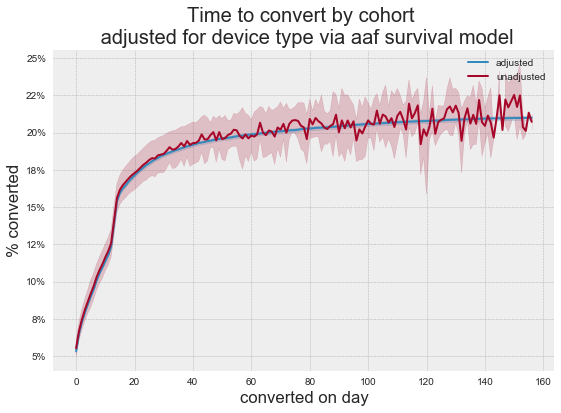

In [54]:
ax = sns.lineplot(
    data=pd.melt(
            pd.concat([
                aaf.predict_survival_function(X_test.droplevel(level=[0])).T.apply(lambda x: 1-x)
                ,df[df.id.isin(X_test.index.levels[1])].reset_index()\
                    .set_index('id')['start_dt'].apply(lambda x: datetime.strftime(x, '%b-%d')).rename('cohort')
            ], axis=1, join='inner').groupby('cohort').mean().reset_index()
        ,id_vars='cohort'
        ,value_name='survival'
        ,var_name='duration'
        )
    ,x='duration'
    ,y='survival'
    ,ci='sd'
    ,label='adjusted'
)


sns.lineplot(
    data = (df[(df.observed==True)&(df.id.isin(X_test.index.levels[1]))]\
        .groupby(['cohort', 'duration'])['id'].count().groupby(level=[0]).cumsum()/\
        df[(df.id.isin(X_test.index.levels[1]))].groupby(['cohort'])['id'].count()).reset_index()
    ,x='duration'
    ,y='id'
    ,ci='sd'
    ,ax=ax
    ,label='unadjusted'
)

ax.set_title('Time to convert by cohort \n adjusted for device type via aaf survival model')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('converted on day')
ax.set_ylabel('% converted')
ax.legend()

# Impact of previous product launches

Text(0, 0.5, 'conversion rate')

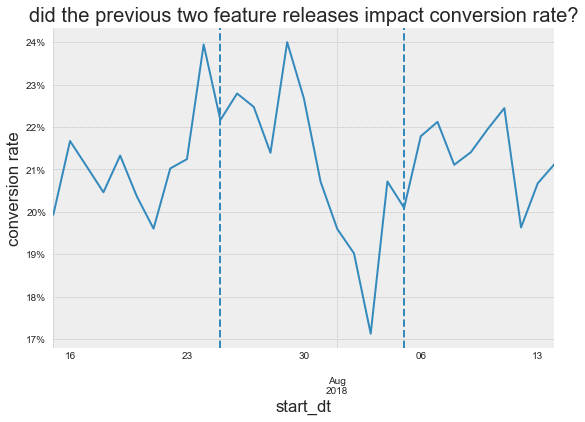

In [55]:
date_of_feature_a = date(2018,7,23)
date_of_feature_b = date(2018,8,5)

ax = df.groupby(pd.Grouper(key='start_dt', freq='1d'))['observed'].mean().plot()
ax.axvline(date(2018,7,25), linestyle='--')

ax.axvline(date(2018,8,5), linestyle='--')

ax.set_title('did the previous two feature releases impact conversion rate?')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_ylabel('conversion rate')

In [56]:
previous_feature_cols = ['feature_a_treatment', 'feature_b_treatment', 'feature_a_control', 'feature_b_control']

X_train, X_test = create_regression_df(
                df[(pd.notnull(df.device))].set_index(['cohort', 'id'])\
                    .assign(feature_a_treatment=lambda df_: df_['start_dt']
                                .apply(lambda x: 0<(datetime.date(x)-date_of_feature_a).days<=7))
                    .assign(feature_b_treatment=lambda df_: df_['start_dt']
                                .apply(lambda x: -7<=(datetime.date(x)-date_of_feature_a).days<0))
                    .assign(feature_a_control=lambda df_: df_['start_dt']
                                .apply(lambda x: 0<(datetime.date(x)-date_of_feature_b).days<=7))
                    .assign(feature_b_control=lambda df_: df_['start_dt']
                                .apply(lambda x: -7<=(datetime.date(x)-date_of_feature_b).days<0))
                    [['observed', 'duration', 'device']+previous_feature_cols]\
                          ,dummy_cols=['device']\
                          ,split=True)

<lifelines.CoxPHFitter: fitted with 46772 observations, 36286 censored>
      duration col = 'duration'
         event col = 'observed'
number of subjects = 46772
  number of events = 10486
    log-likelihood = -111043.17
  time fit was run = 2019-04-29 14:49:29 UTC

---
                     coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
feature_a_treatment  0.13      1.14      0.03   4.80 <0.005     19.30        0.08        0.18
feature_b_treatment  0.03      1.03      0.03   1.06   0.29      1.80       -0.03        0.09
feature_a_control    0.06      1.06      0.03   1.90   0.06      4.13       -0.00        0.11
feature_b_control   -0.01      0.99      0.03  -0.29   0.77      0.37       -0.06        0.05
device_mobile       -0.44      0.64      0.03 -15.91 <0.005    186.91       -0.50       -0.39
device_tablet       -0.69      0.50      0.03 -25.58 <0.005    477.17       -0.75       -0.64
---
Concordance = 0.58
Log-likelihood ratio test = 877.26 on 6 df, -lo

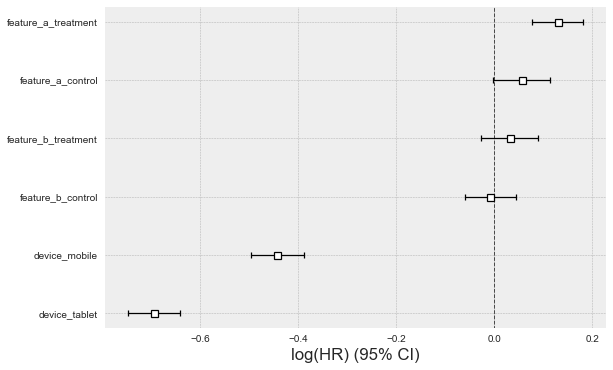

In [57]:
cph = CoxPHFitter()
cph.fit(X_train,  duration_col='duration', event_col='observed')
cph.print_summary()
cph.plot()
plt.savefig('{}/{}'.format(save_directory, 'cph_feature_significance.png'), bbox_inches='tight')

In [58]:
cph.check_assumptions(X_train, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                          test_statistic    p  -log2(p)
device_mobile       km              0.99 0.32      1.65
                    rank            0.85 0.36      1.49
device_tablet       km              0.23 0.63      0.66
                    rank            0.47 0.49      1.02
feature_a_control   k

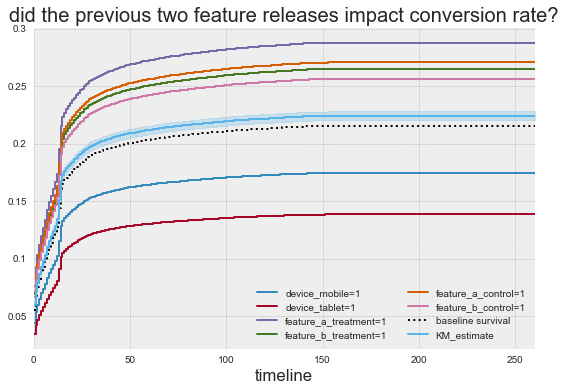

In [59]:
#plotting 1 - survival curve. This is more intuitive way to think about it and converting from hazards to survival sucks
ax = cph.plot_covariate_groups(['device_mobile', 'device_tablet'] + previous_feature_cols, values=np.eye(2 + len(previous_feature_cols)))

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(X_train['duration'], event_observed=X_train['observed'])
ax = kmf.plot(ax=ax, invert_y_axis=True)
ax.set_title('did the previous two feature releases impact conversion rate?')
ax.legend(loc=4, ncol=2)

# Tracking Progress

### Day 0

In [60]:
'''
import trial data from new product
'''
new_product_df = pd.DataFrame(connector.SheetConn('new_cohorts').sheet1.get_all_records())

#manually parsing string dates because gspread dtypes suck
sheets_date_format = '%Y-%m-%d %H:%M:%S'
new_product_df['start_dt'] = new_product_df['start_dt']\
    .apply(lambda x: datetime.strptime(x, sheets_date_format))
new_product_df['completion_dt'] = new_product_df['completion_dt']\
    .apply(lambda x: datetime.strptime(x, sheets_date_format) if x!='' else None)

#use the lifelines datetimes_to_durations function for a observed (boolean) column and a duration (time it took to subscribe)
new_product_df['duration'], new_product_df['observed'] = datetimes_to_durations(\
        new_product_df['start_dt'], new_product_df['completion_dt'], fill_date='2019-04-01')

new_product_df = new_product_df[new_product_df.cohort!=3]
new_product_df['device'].replace('', np.NaN, inplace=True)
new_product_df['browser'].replace('', np.NaN, inplace=True)

In [61]:
get_ci = lambda x: scipy.stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=scipy.stats.sem(x))

def get_survival_function(df, aaf):
    df = create_regression_df(df, dummy_cols=['device']).reset_index(level=[1], drop=True)
    survival_df = aaf.predict_survival_function(df)
    output_df = pd.concat([
        survival_df.mean(axis=1)
        ,survival_df.apply(lambda x: get_ci(x), axis=1).apply(pd.Series)
    ], axis=1).apply(lambda x: 1-x)
    output_df.columns=['mean', 'lower_bound', 'upper_bound']
    return output_df

Text(115, 0.175, '98.8% of conversions\nobserved by day 120')

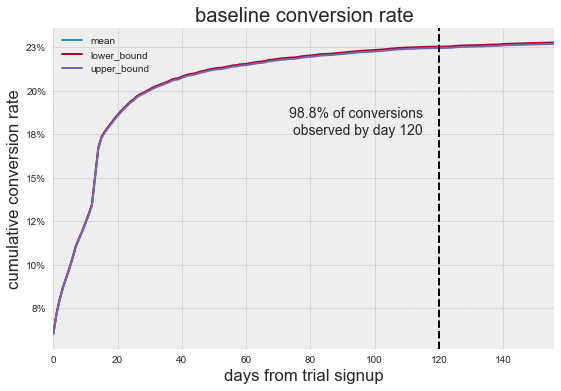

In [62]:
X_train, X_test = create_regression_df(
                          df[(pd.notnull(df.device))].set_index(['cohort', 'id'])\
                            [['observed', 'duration', 'device']]\
                          ,dummy_cols=['device']\
                          ,split=True)
aaf.fit(X_test, duration_col='duration', event_col='observed')

ax = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).plot()

ax.set_title('baseline conversion rate')
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_ylabel('cumulative conversion rate')
ax.set_xlabel('days from trial signup')
ax.axvline(120, linestyle='--', color='k')
ax.text(115, ax.get_yticks()[5],'{:.1f}% of conversions\nobserved by day 120'\
                .format(df[df.observed==True].groupby('duration').size()\
                            .div(df.observed.sum())\
                        .cumsum()[120]*100)
            ,horizontalalignment='right')


[Text(0, 0, '4.6%'),
 Text(0, 0, '4.8%'),
 Text(0, 0, '5.0%'),
 Text(0, 0, '5.2%'),
 Text(0, 0, '5.4%'),
 Text(0, 0, '5.6%'),
 Text(0, 0, '5.8%'),
 Text(0, 0, '6.0%'),
 Text(0, 0, '6.2%'),
 Text(0, 0, '6.4%')]

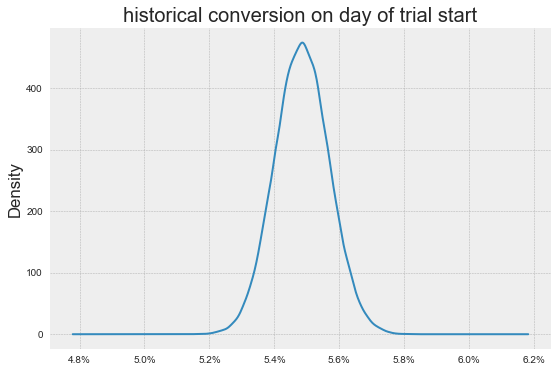

In [63]:
#prior for day 1 conversions
after_day = 0
prior_alpha = (df.duration<=after_day).sum()
prior_beta = (df.duration>after_day).sum()
ax = pd.Series(np.random.beta(prior_alpha, prior_beta, size=100000)).plot(kind='density')
ax.set_title('historical conversion on day of trial start')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])

### Day 1

#### Tracking intended effect

[Text(0, 0, '4.6%'),
 Text(0, 0, '4.8%'),
 Text(0, 0, '5.0%'),
 Text(0, 0, '5.2%'),
 Text(0, 0, '5.4%'),
 Text(0, 0, '5.6%'),
 Text(0, 0, '5.8%'),
 Text(0, 0, '6.0%'),
 Text(0, 0, '6.2%'),
 Text(0, 0, '6.4%')]

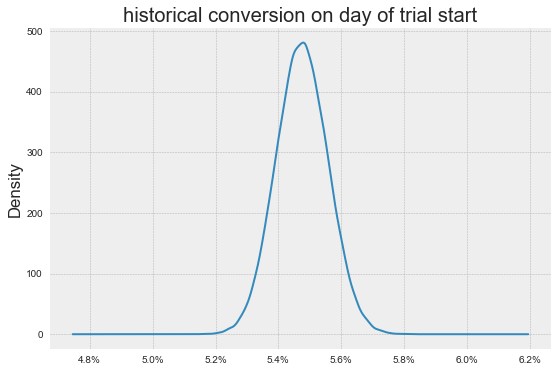

In [64]:
#prior for day 1 conversions
after_day = 0
new_alpha = (new_product_df[new_product_df.cohort==32].duration<=after_day).sum()
new_beta = (new_product_df[new_product_df.cohort==32].duration>after_day).sum()
ax = pd.Series(np.random.beta(new_alpha + prior_alpha, new_beta + prior_beta, size=100000)).plot(kind='density')
ax.set_title('historical conversion on day of trial start')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])

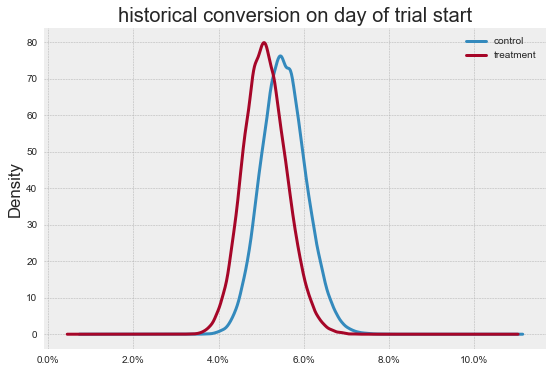

In [65]:
#prior for day 1 conversions
after_day = 0
n_observations = (new_product_df.cohort==32).sum()

control_alpha = (df.sample(n_observations).duration<=after_day).sum()
control_beta = (df.sample(n_observations).duration>after_day).sum()
control_group = np.random.beta(control_alpha, control_beta, size=100000)
ax = pd.Series(control_group).plot(kind='density', label='control', linewidth=3)

treatment_alpha = (new_product_df[new_product_df.cohort==32].duration<=after_day).sum()
treatment_beta = (new_product_df[new_product_df.cohort==32].duration>after_day).sum()
treatment_group = np.random.beta(treatment_alpha, treatment_beta, size=100000)
pd.Series(treatment_group).plot(ax=ax, kind='density', label='treatment', linewidth=3)


ax.set_title('historical conversion on day of trial start')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.legend()

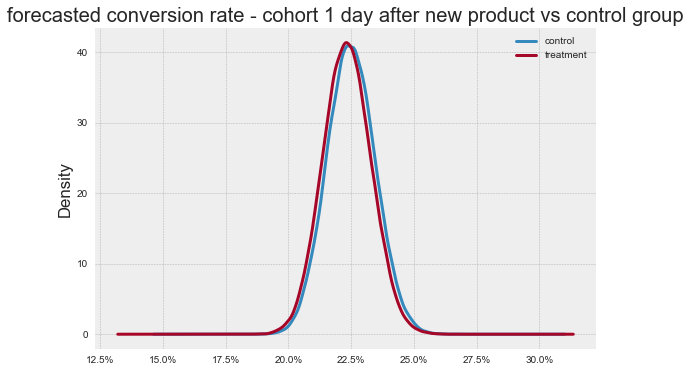

In [66]:
#prior for day 1 conversions
after_day = 0
n_observations = (new_product_df.cohort==32).sum()

aaf.fit(X_test, event_col='observed', duration_col='duration')

adjusted_conversion_rate_control = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
control_alpha = adjusted_conversion_rate_control*n_observations
control_beta = n_observations*(1-adjusted_conversion_rate_control)
control_group = np.random.beta(control_alpha, control_beta, size=100000)
ax = pd.Series(control_group).plot(kind='density', label='control', linewidth=3)


adjusted_conversion_rate_treatment = get_survival_function(new_product_df[new_product_df.cohort==32+after_day]\
        .set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
treatment_alpha = adjusted_conversion_rate_treatment*n_observations
treatment_beta = n_observations*(1-adjusted_conversion_rate_treatment)
treatment_group = np.random.beta(treatment_alpha, treatment_beta, size=100000)
pd.Series(treatment_group).plot(ax=ax, kind='density', label='treatment', linewidth=3)


ax.set_title('forecasted conversion rate - cohort 1 day after new product vs control group')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.legend()
plt.savefig('{}/{}'.format(save_directory, 'adjusted_conversion_comparison_day1.png'), bbox_inches='tight')

[Text(0, 0, '-30.0%'),
 Text(0, 0, '-20.0%'),
 Text(0, 0, '-10.0%'),
 Text(0, 0, '0.0%'),
 Text(0, 0, '10.0%'),
 Text(0, 0, '20.0%'),
 Text(0, 0, '30.0%')]

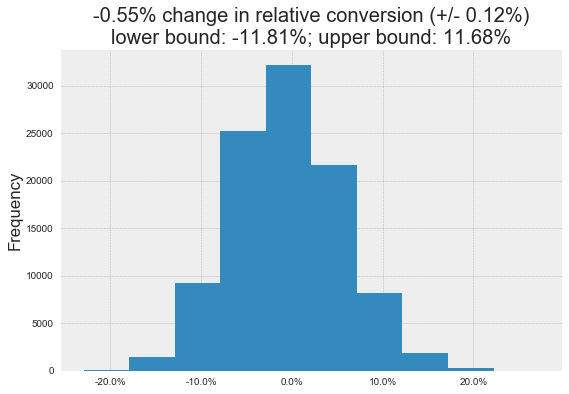

In [67]:
ax = pd.Series(treatment_group / control_group - 1).plot(kind='hist')

ax.set_title('{:.2f}% change in relative conversion (+/- {:.2f}%)\nlower bound: {:.2f}%; upper bound: {:.2f}%'\
             .format((treatment_group / control_group - 1).mean() * 100,
                     pd.Series(treatment_group / control_group - 1).quantile(0.975) - pd.Series(treatment_group / control_group - 1).quantile(0.5),
                     pd.Series(treatment_group / control_group - 1).quantile(0.025) * 100,
                     pd.Series(treatment_group / control_group - 1).quantile(0.975) * 100
                    ))
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])

In [68]:
#trials started by device
pd.concat([
    df['device'].value_counts(normalize=True).rename('control')
    ,new_product_df[(new_product_df.cohort==32+after_day)]['device'].value_counts(normalize=True).rename('treatment')
], axis=1)

,control,treatment
desktop,0.571609,0.547976
tablet,0.244549,0.232390
mobile,0.183842,0.219634


/Users/rob/.pyenv/versions/3.7.2/envs/wbs/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


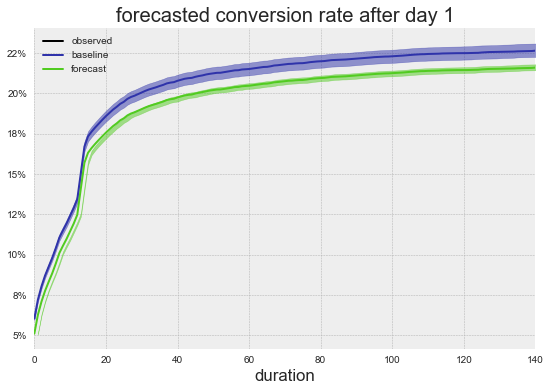

In [69]:
# let's turn the above into 
after_day = 0
infected = new_product_df[(new_product_df.cohort==32+after_day)&\
                          (new_product_df.duration<=after_day)]\
            .groupby('duration')['observed'].sum().cumsum().div(
            len(new_product_df[(new_product_df.cohort==32+after_day)]))


ax = infected.plot(label='observed', color='k')

aaf.fit(X_test, event_col='observed', duration_col='duration')
baseline_survival = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf)
baseline_survival['mean'].plot(ax=ax, label='baseline', color='#2F33AA')
ax.fill_between(range(len(baseline_survival)), baseline_survival['lower_bound']*0.98,\
                                               baseline_survival['upper_bound']*1.02, alpha=0.5, color='#2F33AA')


aaf.fit(X_test, event_col='observed', duration_col='duration')
forecasted = get_survival_function(new_product_df[(new_product_df.cohort==32+after_day)&\
                                                  (new_product_df.duration>after_day)]\
        .set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf)
forecasted = forecasted.apply(lambda x: x - (forecasted.loc[0, 'mean']-new_alpha/n_observations))
forecasted['mean'].plot(ax=ax, label='forecast', color='#51CB20')
ax.fill_between(range(len(infected), len(forecasted)+len(infected)), forecasted['lower_bound']*0.98,
                                                        forecasted['upper_bound']*1.02, alpha=0.5, color='#51CB20')
ax.legend()
ax.set_xlim(0, 140)

ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_title('forecasted conversion rate after day {}'.format(after_day+1))
plt.savefig('{}/{}'.format(save_directory, 'adjusted_conversion_comparison_day1.png'), bbox_inches='tight')
plt.savefig('{}/{}'.format(save_directory, 'adjusted_conversion_comparison_survival_day1.png'), bbox_inches='tight')

In [70]:
stat, p, dof, expected =chi2_contingency(\
pd.DataFrame({'Before new product launch': {'trials': len(df),
                                            'conversions': (df.duration==0).sum()
                                          },
              'After new product launch': {'trials': (new_product_df.cohort==32+after_day).sum(),
                                           'conversions':(new_product_df[(new_product_df.cohort==32+after_day)].duration==0).sum()
                                          }
             })
)
stat, chi2.ppf(0.95, dof), p<0.05


(0.4225383890292921, 3.841458820694124, False)

#### Tracking our Assumptions

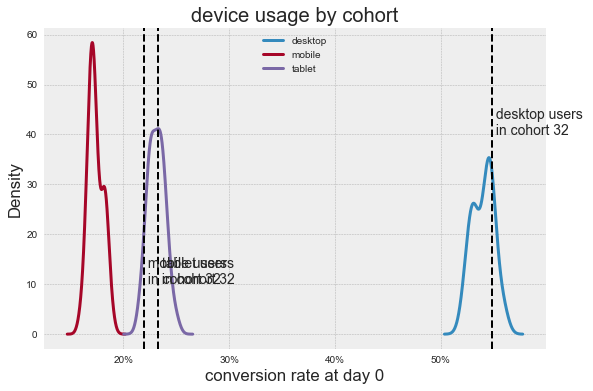

In [71]:
'''
Where the first cohort falls relative to the historical population 
'''
cohort_to_plot=32
ax = pd.pivot_table(
    df.groupby(['cohort', 'device']).size().div(df.groupby('cohort').size()).reset_index()
    ,index='cohort'
    ,columns='device'
).droplevel(level=[0], axis=1).plot(kind='density', linewidth=3)

ax.set_title('device usage by cohort'.format(after_day))
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('conversion rate at day {}'.format(after_day))

for label, value in new_product_df[(new_product_df.cohort==cohort_to_plot)]\
                        ['device'].value_counts(normalize=True).to_dict().items():
    ax.axvline(value, linestyle='--', color='k')
    ax.text(value, ax.get_yticks()[int(value*10)], ' {} users \n in cohort {}'.format(label, cohort_to_plot), horizontalalignment='left')

ax.legend(loc=9)
    

In [72]:
stat, p, dof, expected = chi2_contingency(pd.concat([
    df[df.observed==True]['device'].value_counts(normalize=True).rename('control')
    ,new_product_df[new_product_df.observed==True]['device'].value_counts(normalize=True).rename('treatment')
], axis=1))

{'stat': stat, 'ppf': chi2.ppf(0.95, dof), 'is_significant': p<0.05}

{'stat': 1.3595504843231333e-05,
 'ppf': 5.991464547107979,
 'is_significant': False}

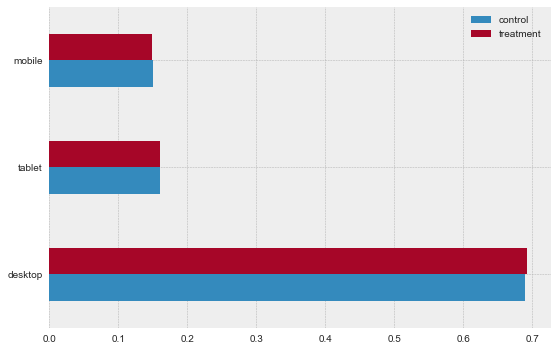

In [73]:
'''
A chi square test is just overkill at this point
'''
pd.concat([
    df[df.observed==True]['device'].value_counts(normalize=True).rename('control')
    ,new_product_df[new_product_df.observed==True]['device'].value_counts(normalize=True).rename('treatment')
], axis=1).plot(kind='barh')

### Day 7

#### Tracking intended effect

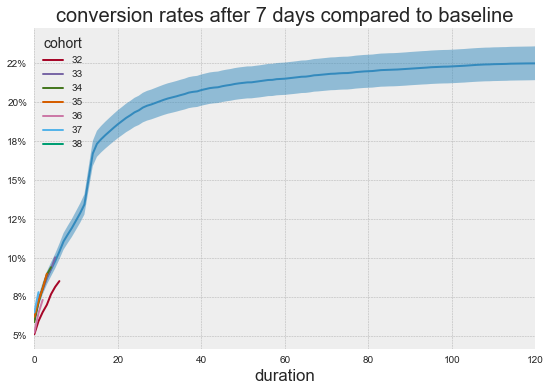

In [74]:
after_day = 7
current_day = date(2018, 8, 15) + timedelta(days=after_day)

aaf.fit(X_test, event_col='observed', duration_col='duration')
z = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf)
ax = z['mean'].plot(label='baseline')
ax.fill_between(range(len(z)), z['lower_bound']*0.95, z['upper_bound']*1.05, alpha=0.5)

pd.pivot_table(
    new_product_df[(new_product_df.cohort<32+after_day)&\
                   (new_product_df.completion_dt<=current_day)]\
      .groupby(['cohort', 'duration']).size().reset_index()\
    ,index='duration'
    ,columns='cohort')\
.cumsum().droplevel(level=[0], axis=1).div(new_product_df.groupby('cohort').size())\
.dropna(how='all', axis=1).plot(ax=ax)

ax.set_xlim(0, 120) 
ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_title('conversion rates after {} days compared to baseline'.format(after_day))
plt.savefig('{}/{}'.format(save_directory, 'infected_vs_baseline_day7.png'), bbox_inches='tight')

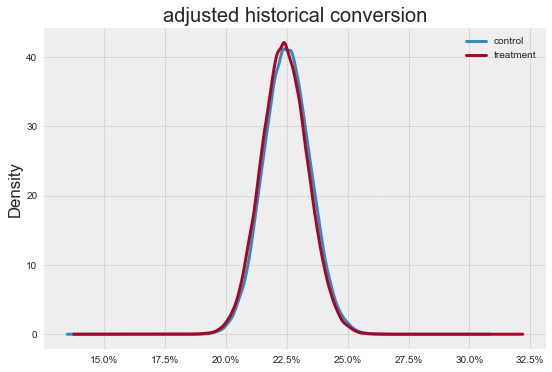

In [75]:
#prior for day 1 conversions
after_day = 7
n_observations = (new_product_df.cohort==32).sum()

aaf.fit(X_test, event_col='observed', duration_col='duration')

adjusted_conversion_rate_control = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
control_alpha = adjusted_conversion_rate_control*n_observations
control_beta = n_observations*(1-adjusted_conversion_rate_control)
control_group = np.random.beta(control_alpha, control_beta, size=100000)
ax = pd.Series(control_group).plot(kind='density', label='control', linewidth=3)


adjusted_conversion_rate_treatment = get_survival_function(new_product_df[new_product_df.cohort==32+after_day]\
        .set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
treatment_alpha = adjusted_conversion_rate_treatment*n_observations
treatment_beta = n_observations*(1-adjusted_conversion_rate_treatment)
treatment_group = np.random.beta(treatment_alpha, treatment_beta, size=100000)
pd.Series(treatment_group).plot(ax=ax, kind='density', label='treatment', linewidth=3)


ax.set_title('adjusted historical conversion')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.legend()


In [76]:
summary = {}
for i, cohort in enumerate([i for i in new_product_df['cohort'].unique() if i<=after_day+32]):
    infected = new_product_df[(new_product_df.cohort==cohort)&\
                              (new_product_df.duration<=after_day-i)]['observed'].sum()
    size = (new_product_df.cohort==cohort).sum()
    susceptible = size-infected
    aaf.fit(X_test[X_test.duration>after_day-i], event_col='observed', duration_col='duration')
    forecasted = get_survival_function(new_product_df[(new_product_df.cohort==cohort)&\
                                                      (new_product_df.duration>after_day-i)]\
                                    .set_index(['cohort', 'id'])\
                                    [['observed', 'duration', 'device']]
                        , aaf).loc[121, 'mean']
    summary[cohort] = {'size': size, 'observed':infected,\
                       'remaining': susceptible, 'observed_conversion_rate': infected/size,\
                       'projected_future_conversions': forecasted*size,\
                       'projected_conversion': forecasted+infected/size}

cohorts_summary = pd.DataFrame(summary).T

Text(0.5, 1.0, 'significance by days observed and conversion date observed')

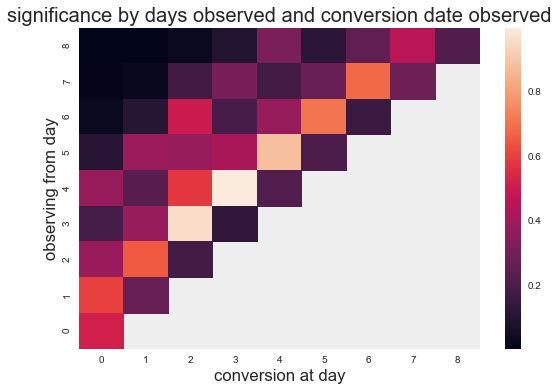

In [77]:
p_vals = []
for observe_at_day in range(1, 10):
    d = {}
    for conversion_at_day in range(0, observe_at_day):
        current_day = date(2018, 8, 15) + timedelta(days=observe_at_day)
        new_product_successes_group = pd.pivot_table(
                                    new_product_df[(new_product_df.cohort<32+observe_at_day)&\
                                                   (new_product_df.completion_dt<=current_day)]\
                                      .groupby(['cohort', 'duration']).size().reset_index()\
                                ,index='duration'
                                , columns='cohort')\
            .cumsum().droplevel(level=[0], axis=1)\
        .loc[conversion_at_day]
        new_product_successes = new_product_successes_group.sum()
        new_product_trials = new_product_df.cohort.isin(new_product_successes_group.dropna().index).sum()
        control_trials = len(df)
        control_successes = (df.duration<=conversion_at_day).sum()

        beta_data = pd.DataFrame({'Before new product launch': {'trials': control_trials,
                                                    'conversions': control_successes
                                                  },
                      'After new product launch': {'trials': new_product_trials,
                                                   'conversions':new_product_successes
                                                  }
                     })
        stat, p, dof, expected = chi2_contingency(beta_data)
        d[conversion_at_day] = p
    p_vals.append(d)
    
ax = sns.heatmap(pd.DataFrame(p_vals).sort_index(ascending=False))
ax.set_xlabel('conversion at day')
ax.set_ylabel('observing from day')
ax.set_title('significance by days observed and conversion date observed')

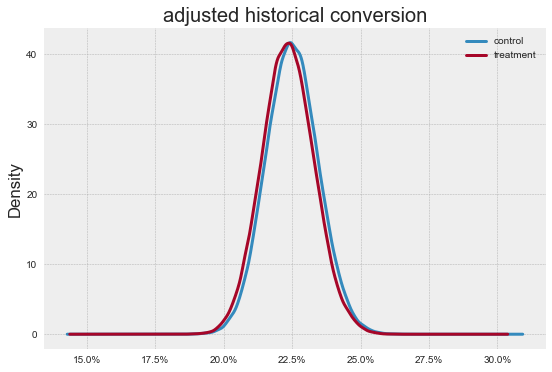

In [78]:
#prior for day 1 conversions
after_day = 0
n_observations = (new_product_df.cohort==32).sum()

aaf.fit(X_test, event_col='observed', duration_col='duration')

adjusted_conversion_rate_control = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
control_alpha = adjusted_conversion_rate_control*n_observations
control_beta = n_observations*(1-adjusted_conversion_rate_control)
control_group = np.random.beta(control_alpha, control_beta, size=100000)
ax = pd.Series(control_group).plot(kind='density', label='control', linewidth=3)


adjusted_conversion_rate_treatment = get_survival_function(new_product_df[new_product_df.cohort==32+after_day]\
        .set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
treatment_alpha = adjusted_conversion_rate_treatment*n_observations
treatment_beta = n_observations*(1-adjusted_conversion_rate_treatment)
treatment_group = np.random.beta(treatment_alpha, treatment_beta, size=100000)
pd.Series(treatment_group).plot(ax=ax, kind='density', label='treatment', linewidth=3)


ax.set_title('adjusted historical conversion')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.legend()

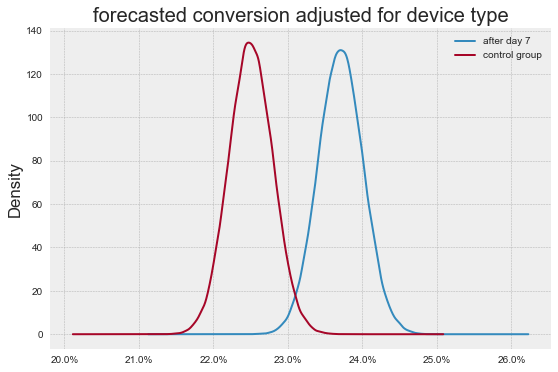

In [79]:
after_day = 7
summary = {}
for i, cohort in enumerate([i for i in new_product_df['cohort'].unique() if i<=after_day+32]):
    infected = new_product_df[(new_product_df.cohort==cohort)&\
                              (new_product_df.duration<=after_day-i)]['observed'].sum()
    size = (new_product_df.cohort==cohort).sum()
    susceptible = size-infected
    aaf.fit(X_test[X_test.duration>after_day-i], event_col='observed', duration_col='duration')
    forecasted = get_survival_function(new_product_df[(new_product_df.cohort==cohort)&\
                                                      (new_product_df.duration>after_day-i)]\
                                    .set_index(['cohort', 'id'])\
                                    [['observed', 'duration', 'device']]
                        , aaf).loc[121, 'mean']
    summary[cohort] = {'size': size, 'observed':infected,\
                       'remaining': susceptible, 'observed_conversion_rate': infected/size,\
                       'projected_future_conversions': forecasted*size,\
                       'projected_conversion': forecasted+infected/size}

cohorts_summary = pd.DataFrame(summary).T



n_samples = cohorts_summary['size'].sum()
aaf.fit(X_test, event_col='observed', duration_col='duration')
adjusted_conversion_rate_control = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
control_alpha = adjusted_conversion_rate_control*n_samples
control_beta = n_samples*(1-adjusted_conversion_rate_control)
control_group = np.random.beta(control_alpha, control_beta, size=100000)


treatment_alpha = n_samples * cohorts_summary['projected_conversion'].mean()
treatment_beta = n_samples * (1 - cohorts_summary['projected_conversion'].mean())
treatment_group = np.random.beta(treatment_alpha, treatment_beta, size=100000)

ax = pd.Series(treatment_group).plot(kind='density', label='after day {}'.format(after_day))
pd.Series(control_group).plot(kind='density', label='control group')

ax.legend()

ax.set_title('forecasted conversion adjusted for device type')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
plt.savefig('{}/{}'.format(save_directory, 'adjusted_conversion_day7.png'), bbox_inches='tight')

In [80]:
cohorts_summary[['size', 'observed', 'remaining', 'projected_future_conversions', 'projected_conversion']]

,size,observed,remaining,projected_future_conversions,projected_conversion
32,1904.0,178.0,1726.0,244.299405,0.221796
33,2880.0,307.0,2573.0,387.347100,0.241093
34,2521.0,252.0,2269.0,353.105483,0.240026
35,1881.0,179.0,1702.0,274.391590,0.241038
36,2712.0,214.0,2498.0,410.776363,0.230375
37,2603.0,221.0,2382.0,409.926496,0.242384
38,2926.0,224.0,2702.0,483.225081,0.241704
39,2475.0,158.0,2317.0,431.579756,0.238214


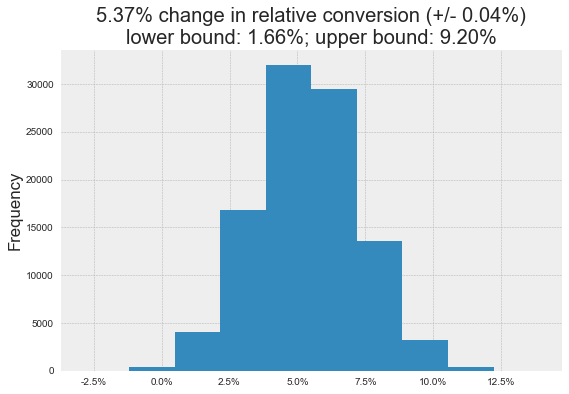

In [81]:
# control_group = np.random.beta(n_samples, control_conversion_rate*n_samples, 100000)
# treatment_group = np.random.beta(n_samples, forecasted_conversion_rate*n_samples, 100000)
ax = pd.Series(treatment_group / control_group - 1).plot(kind='hist')

ax.set_title('{:.2f}% change in relative conversion (+/- {:.2f}%)\nlower bound: {:.2f}%; upper bound: {:.2f}%'\
             .format((treatment_group / control_group - 1).mean() * 100,
                     pd.Series(treatment_group / control_group - 1).quantile(0.975) - pd.Series(treatment_group / control_group - 1).quantile(0.5),
                     pd.Series(treatment_group / control_group - 1).quantile(0.025) * 100,
                     pd.Series(treatment_group / control_group - 1).quantile(0.975) * 100
                    ))
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
plt.savefig('{}/{}'.format(save_directory, 'conversion_lift_day7.png'), bbox_inches='tight')

In [84]:
stat, p, dof, expected =chi2_contingency(\
pd.DataFrame({'Before new product launch': {'trials': n_samples,
                                            'conversions': n_samples*adjusted_conversion_rate_control
                                          },
              'After new product launch': {'trials': n_samples,
                                           'conversions': n_samples*cohorts_summary['projected_conversion'].mean()
                                          }
             })
)
stat, chi2.ppf(0.95, dof), p<0.05

(5.016473246013539, 3.841458820694124, True)

#### Tracking our assumptions

In [85]:
pd.concat([
    df[df.observed==True]['device'].value_counts(normalize=True).rename('control')
    ,new_product_df[(new_product_df.observed==True)&(new_product_df.start_dt<current_day)]\
        ['device'].value_counts(normalize=True).rename('treatment')
], axis=1)

,control,treatment
desktop,0.690039,0.690358
tablet,0.159961,0.161750
mobile,0.150000,0.147892


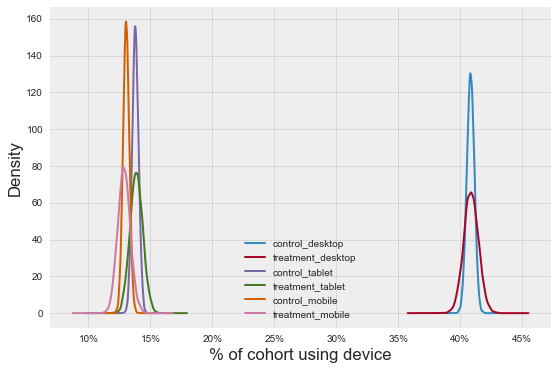

In [86]:
current_day = date(2018, 8, 15) + timedelta(days=after_day)
device_ratio = pd.concat([
    df[df.observed==True]['device'].value_counts().rename('control')
    ,new_product_df[(new_product_df.observed==True)&(new_product_df.start_dt<current_day)]\
        ['device'].value_counts().rename('treatment')
], axis=1)

device_betas = {}
for device in device_ratio.index:
    for group in ['control', 'treatment']:
        device_betas['{}_{}'.format(group, device)] = np.random.beta(device_ratio[group].sum(),\
                                                device_ratio.loc[device, group], 10000)
ax = pd.DataFrame(device_betas).apply(lambda x: 1-x).plot(kind='density')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('% of cohort using device'.format(after_day))
plt.savefig('{}/{}'.format(save_directory, 'device_mix_assumption.png'), bbox_inches='tight')

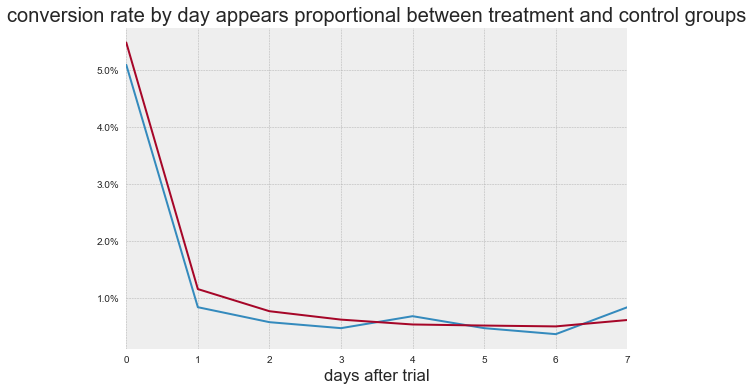

In [87]:
ax = new_product_df[(new_product_df.cohort==32)&(new_product_df.duration<=after_day)]\
        .groupby('duration').size().div((new_product_df.cohort==32).sum()).plot(label='new product cohort')

df[df.duration<=after_day].groupby('duration').size().div(len(df)).plot(ax=ax, label='control group')

ax.set_yticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('days after trial')
ax.set_title('conversion rate by day appears proportional between treatment and control groups')
plt.savefig('{}/{}'.format(save_directory, 'proportionality_assumption_day_14.png'), bbox_inches='tight')

### Day 14

#### Tracking intended effect

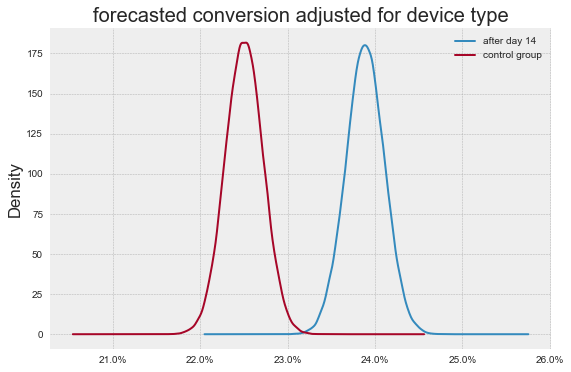

In [88]:
after_day = 14
summary = {}
for i, cohort in enumerate([i for i in new_product_df['cohort'].unique() if i<=after_day+32]):
    infected = new_product_df[(new_product_df.cohort==cohort)&\
                              (new_product_df.duration<=after_day-i)]['observed'].sum()
    size = (new_product_df.cohort==cohort).sum()
    susceptible = size-infected
    aaf.fit(X_test[X_test.duration>after_day-i], event_col='observed', duration_col='duration')
    forecasted = get_survival_function(new_product_df[(new_product_df.cohort==cohort)&\
                                                      (new_product_df.duration>after_day-i)]\
                                    .set_index(['cohort', 'id'])\
                                    [['observed', 'duration', 'device']]
                        , aaf).loc[121, 'mean']
    summary[cohort] = {'size': size, 'observed':infected,\
                       'remaining': susceptible, 'observed_conversion_rate': infected/size,\
                       'projected_future_conversions': forecasted*size,\
                       'projected_conversion': forecasted+infected/size}

cohorts_summary = pd.DataFrame(summary).T



n_samples = cohorts_summary['size'].sum()
aaf.fit(X_test, event_col='observed', duration_col='duration')
adjusted_conversion_rate_control = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf).loc[121, 'mean']
control_alpha = adjusted_conversion_rate_control*n_samples
control_beta = n_samples*(1-adjusted_conversion_rate_control)
control_group = np.random.beta(control_alpha, control_beta, size=100000)


treatment_alpha = n_samples * cohorts_summary['projected_conversion'].mean()
treatment_beta = n_samples * (1 - cohorts_summary['projected_conversion'].mean())
treatment_group = np.random.beta(treatment_alpha, treatment_beta, size=100000)

ax = pd.Series(treatment_group).plot(kind='density', label='after day {}'.format(after_day))
pd.Series(control_group).plot(kind='density', label='control group')

ax.legend()

ax.set_title('forecasted conversion adjusted for device type')
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
plt.savefig('{}/{}'.format(save_directory, 'adjusted_conversion_rate_day14.png'), bbox_inches='tight')

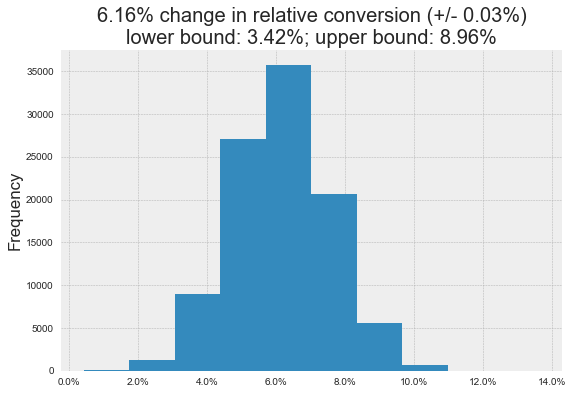

In [89]:
ax = pd.Series(treatment_group / control_group - 1).plot(kind='hist')

ax.set_title('{:.2f}% change in relative conversion (+/- {:.2f}%)\nlower bound: {:.2f}%; upper bound: {:.2f}%'\
             .format((treatment_group / control_group - 1).mean() * 100,
                     pd.Series(treatment_group / control_group - 1).quantile(0.975) - pd.Series(treatment_group / control_group - 1).quantile(0.5),
                     pd.Series(treatment_group / control_group - 1).quantile(0.025) * 100,
                     pd.Series(treatment_group / control_group - 1).quantile(0.975) * 100
                    ))
ax.set_xticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_xticks().tolist()])
plt.savefig('{}/{}'.format(save_directory, 'conversion_lift_day14.png'), bbox_inches='tight')



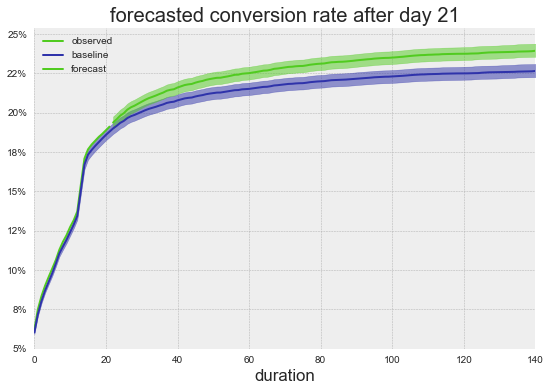

In [90]:
# let's turn the above into 
after_day = 21
infected = new_product_df[(new_product_df.cohort<=32+after_day)&\
                          (new_product_df.duration<=after_day)]\
            .groupby('duration')['observed'].sum().cumsum().div(
            len(new_product_df[(new_product_df.cohort<=32+after_day)]))


ax = infected.plot(label='observed', color='#51CB20')

aaf.fit(X_test, event_col='observed', duration_col='duration')
baseline_survival = get_survival_function(df.set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf)
baseline_survival['mean'].plot(ax=ax, label='baseline', color='#2F33AA')
ax.fill_between(range(len(baseline_survival)), baseline_survival['lower_bound']*0.98,\
                                               baseline_survival['upper_bound']*1.02, alpha=0.5, color='#2F33AA')


aaf.fit(X_test[X_test.duration>after_day], event_col='observed', duration_col='duration')
forecasted = get_survival_function(new_product_df[(new_product_df.cohort==32+after_day)&\
                                       (new_product_df.duration>after_day)]\
        .set_index(['cohort', 'id'])[['observed', 'duration', 'device']], aaf)\
        .apply(lambda x: x+infected.max())

forecasted['mean'].plot(ax=ax, label='forecast', color='#51CB20')
ax.fill_between(range(len(infected), len(forecasted)+len(infected)), forecasted['lower_bound']*0.98,
                                                        forecasted['upper_bound']*1.02, alpha=0.5, color='#51CB20')
ax.legend()
ax.set_xlim(0, 140)

ax.set_yticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_title('forecasted conversion rate after day {}'.format(after_day))
plt.savefig('{}/{}'.format(save_directory, 'conversion_survival_vs_baseline_day21.png'), bbox_inches='tight')

#### Tracking assumptions

Text(0.5, 0, '% of cohort using device')

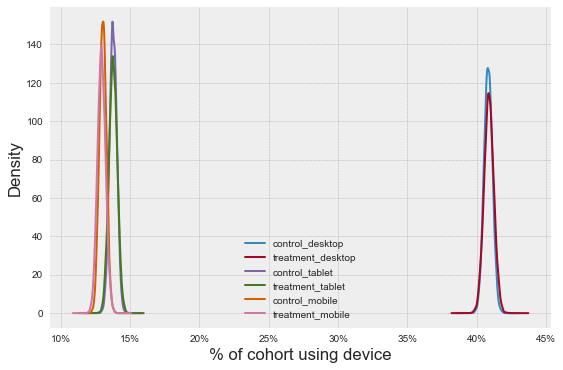

In [91]:
current_day = date(2018, 8, 15) + timedelta(days=after_day)
device_ratio = pd.concat([
    df[df.observed==True]['device'].value_counts().rename('control')
    ,new_product_df[(new_product_df.observed==True)&(new_product_df.start_dt<current_day)]\
        ['device'].value_counts().rename('treatment')
], axis=1)

device_betas = {}
for device in device_ratio.index:
    for group in ['control', 'treatment']:
        device_betas['{}_{}'.format(group, device)] = np.random.beta(device_ratio[group].sum(),\
                                                device_ratio.loc[device, group], 10000)
ax = pd.DataFrame(device_betas).apply(lambda x: 1-x).plot(kind='density')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('% of cohort using device'.format(after_day))

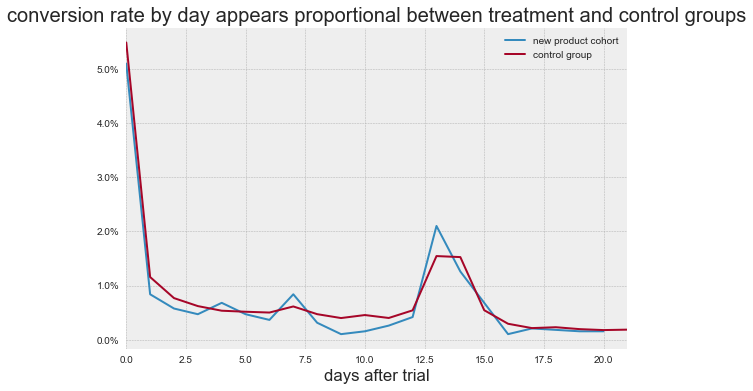

In [92]:
ax = new_product_df[(new_product_df.cohort==32)&(new_product_df.duration<=after_day)]\
        .groupby('duration').size().div((new_product_df.cohort==32).sum()).plot(label='new product cohort')

df[df.duration<=after_day].groupby('duration').size().div(len(df)).plot(ax=ax, label='control group')

ax.set_yticklabels(['{:0.1f}%'.format(x*100) for x in ax.get_yticks().tolist()])
ax.set_xlabel('days after trial')
ax.set_title('conversion rate by day appears proportional between treatment and control groups')
ax.legend()